### Text Sentiment Analysis

#### This is version four

This script performs sentiment analysis on a dataset of airline tweets to classify them into three categories: negative, neutral, and positive. The analysis process consists of three main steps:

Preprocessing script: This script processes the raw dataset by cleaning and tokenizing the text data, encoding the sentiment labels, and splitting the dataset into training and testing sets. The preprocessed data is saved to a CSV file for further use.

Ensemble script: This script reads the preprocessed data and trains three different classifiers (Logistic Regression, Multinomial Naive Bayes, and Random Forest) on the training data. It then combines these classifiers into an ensemble model using majority voting. The ensemble model's predictions for the test data are evaluated using a classification report, and both true labels and ensemble predictions are saved to a CSV file.

Plotting script: This script reads the true labels and ensemble predictions from the CSV file generated by the ensemble script, calculates the confusion matrix, and plots it as a heatmap. The confusion matrix provides a visual representation of the ensemble model's performance, highlighting areas of accurate classification and potential misclassifications.
Together, these scripts demonstrate a complete pipeline for creating and evaluating an ensemble classifier for airline sentiment analysis using majority voting to combine the results of multiple base classifiers.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Copy the data to your local drive
!cp /content/drive/MyDrive/archive/archive-3/Tweets.csv /content/

In [3]:
import pandas as pd
from pandas import Series, DataFrame, isnull, notnull
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a function to clean the text
def clean_text(text):
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Convert emoticons to words
    text = re.sub(r':\)', ' smile ', text)
    text = re.sub(r':\(', ' sad ', text)

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a single string
    text = ' '.join(tokens)
    
    return text

# Load the Twitter data
data = pd.read_csv("Tweets.csv")

# Apply the clean_text function to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Save preprocessed data to a new file
data.to_csv('preprocessed_tweets.csv', index=False)





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

def majority_voting(predictions):
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)

# Load the dataset
data_path = "Tweets.csv"
df = pd.read_csv(data_path)

# Vectorize the text data
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["text"]).toarray()
y = df["airline_sentiment"]

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train individual models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{model_name} trained.")

# Make predictions with individual models
encoded_predictions = [model.predict(X_test) for model in models.values()]
encoded_predictions = np.column_stack(encoded_predictions)

# Apply majority voting
ensemble_predictions = majority_voting(encoded_predictions)

# Print classification report
print("Classification Report for Ensemble Model (Majority Voting):")
print(classification_report(y_test, ensemble_predictions))

# Create a DataFrame with the true labels and ensemble predictions
output_df = pd.DataFrame({'true_labels': y_test, 'ensemble_predictions': ensemble_predictions})

# Save the DataFrame to a CSV file
output_df.to_csv('ensemble_predictions.csv', index=False)


Logistic Regression trained.
Multinomial Naive Bayes trained.
Random Forest trained.
Classification Report for Ensemble Model (Majority Voting):
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1889
           1       0.67      0.54      0.60       580
           2       0.80      0.66      0.72       459

    accuracy                           0.81      2928
   macro avg       0.77      0.71      0.73      2928
weighted avg       0.80      0.81      0.80      2928



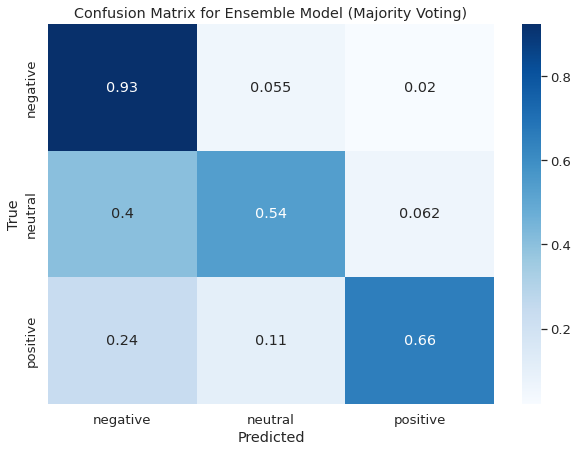

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Read the true labels and ensemble predictions from the CSV file
data = pd.read_csv('ensemble_predictions.csv')
true_labels = data['true_labels']
ensemble_predictions = data['ensemble_predictions']

# Create a confusion matrix
cm = confusion_matrix(true_labels, ensemble_predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Ensemble Model (Majority Voting)')

# Save the plot as an image file
plt.savefig('ensemble_confusion_matrix.png')

# Show the plot
plt.show()
